In [144]:
%matplotlib inline
import networkx as nx
import community
import random
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from random import choice
import subprocess
import re
from collections import defaultdict
from ulf import ulf

# Experiment 1

In [597]:
def graphlist_to_pajek(graphlist):
    edgelist = []
    for l, G in enumerate(graphlist):
        for n1, n2 in G.edges():
            edgelist.append([l, n1, n2])
    return ulf.write_pajek(pd.DataFrame(edgelist, columns=['layer', 'node1', 'node2']))
            

# def morph_from_G1_to_G2(G, Gt, num_swaps):
#     """Exchanges num_swaps edges from G with num_swap edges from Gt"""
#     def _dependent_edge_swaps(Gs, Gt):
        
#         Gc = Gs.copy()
        
#         empty = 0
#         done = False
        
#         try:
#             u, x = choice(list(set(Gc.edges()) - set(Gt.edges())))  # REMOVE random edge not in Gt
#             Gc.remove_edge(u, x)
#         except IndexError:
#             done += 1
        
#         try:
#             v, y = choice(list(set(Gt.edges()) - set(Gc.edges())))  # ADD random edge not in Gc
#             d = Gt.get_edge_data(v, y)
#             Gc.add_edge(v, y, d)
#         except IndexError:
#             done += 1
        
#         if done == 2:
#             done = True
            
#         return Gc, done
    
#     def _jaccard_sim(a, b):
#         return len(a & b) * 1.0 / len(a | b)
    
#     Gs = G.copy()
    
#     for _ in range(num_swaps):
        
#         Gs, done = _dependent_edge_swaps(Gs, Gt)
        
#         if done:
#             if _jaccard_sim(set(Gs.edges()), set(Gt.edges())) != 1:
#                 Gs = Gt
#             break
#     return Gs

def morph_from_G1_to_G2(Gs, Gt, num_swaps):

    Gc = Gs.copy()
    Gt = Gt.copy()

    edges_in_Gc_not_in_Gt = list(set(Gc.edges()) - set(Gt.edges()))
    num_removals_possible = min(num_swaps, len(edges_in_Gc_not_in_Gt))
    u_x = random.sample(edges_in_Gc_not_in_Gt, num_removals_possible)
    Gc.remove_edges_from(u_x)

    edges_in_Gt_not_in_Gc = list(set(Gt.edges()) - set(Gc.edges()))
    num_additions_possible = min(num_swaps, len(edges_in_Gt_not_in_Gc))
    v_y = random.sample(edges_in_Gt_not_in_Gc, num_additions_possible)
    Gc.add_edges_from(v_y)

    def _jaccard_sim(a, b):
        return len(a & b) * 1.0 / len(a | b)
    
    if num_removals_possible != num_swaps & num_additions_possible != num_swaps:
        if _jaccard_sim(set(Gc.edges()), set(Gt.edges())) != 1:
            Gc = Gt

    return Gc

def create_planted_partition_graph(l, k, p_in, p_out):
    def _get_shuffle_mapping(G):
        nodes = G.nodes()[:]
        nodes_shuf = G.nodes()[:]; random.shuffle(nodes_shuf)
        return dict(zip(nodes, nodes_shuf))
    G = nx.planted_partition_graph(l, k, p_in, p_out)
    G = nx.relabel_nodes(G, _get_shuffle_mapping(G))
    partition = community.best_partition(G)
    return G, partition

def get_random_G(num_c, num_nc, max_k):
    G = create_planted_partition_graph(num_c, num_nc, 1.0, 0.0/num_c)[0]
    while np.mean(G.degree().values()) > max_k:
        G.remove_edge(*random.choice(G.edges()))
    return G

def P(pid):
    """Extract number of interlayer links."""
    with open("/tmp/output_infomap/tmpnet%d.net" % pid) as fp:
        net = fp.read()
    subprocess.call(["rm", "/tmp/output_infomap/tmpnet%d.net" % pid])

    interlayer_links = 0
    for l in re.findall(r"\d+ \d+ \d+ \d+ \d.*\d*", net):
        l = map(eval, l.split())
        if l[0] != l[2]:
            interlayer_links += 1

    return interlayer_links
    
def run_Infomap(pajek, pid, method):
    ulf.Infomap(
        pajek,
        '-i', 'multiplex',
        '--multiplex%s-relax-rate' % method, "1.0",
        '--overlapping',
        '--expanded',
        '--clu', '--pajek',
        '-z', '--two-level',
        "pid%d" % pid
    )

In [ ]:
num_nc_arr = [1] #range(2, 10)
num_c_arr = [900 / num_nc for num_nc in num_nc_arr]

#data = defaultdict(dict)

for num_c, num_nc in zip(num_c_arr, num_nc_arr):
    print num_c, num_nc
    
    num_e = num_nc * (num_nc - 1) / 2 * num_c

    # Networks
    G_alpha = get_random_G(num_c, num_nc)
    G_beta = G_alpha.copy()
    G_beta_target = get_random_G(num_c, num_nc)

    # Values to loop over
    swap_vals = range(0, num_e, 10) + [num_e]

    # Results array
    lambda_, S = [], []

    prev_n_swaps = 0
    for n_swaps in swap_vals:
        G_beta = morph_from_G1_to_G2(G_beta, G_beta_target, (n_swaps - prev_n_swaps))

        # Store number of swaps
        prev_n_swaps = n_swaps

        # Make pajek representation of multilayer network
        pajek = graphlist_to_pajek([G_alpha, G_beta])

        # Create unique process ids
        pid_NFC = np.random.randint(int(1e12))
        pid_FC = np.random.randint(int(1e12))

        # Run Infomap
        run_Infomap(pajek, pid_NFC, "-js")
        run_Infomap(pajek, pid_FC, "")

        nl_NFC = P(pid_NFC)
        nl_FC = P(pid_FC)

        lambda_.append(n_swaps * 1.0 / num_e)
        S.append(nl_NFC * 1.0 / nl_FC)
        
    data[(num_c, num_nc)]['lambda_'] = lambda_
    data[(num_c, num_nc)]['S'] = S

In [ ]:
plt.figure(figsize=(3.42, 2.0), frameon=False)
cmap = ulf.cmap_in_range([-1, 9], cmap_style="Blues")
for (num_c, num_nc), data_iter in data.items():
    plt.plot(data_iter['lambda_'], data_iter['S'], label="$C=$%d, $N_c=$%d" % (num_c, num_nc), c=cmap(num_nc))
#plt.legend(fontsize=8)
#plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("$S$")
#plt.savefig("figures/inserlayer_sparsity.pdf")
plt.show()

# Experiment 2

In [625]:
def compute_jsdiv(G_alpha, G_beta):
    jsdiv = []
    for n in G_alpha.nodes():
        G_alpha_n = set(G_alpha.neighbors(n))
        G_beta_n = set(G_beta.neighbors(n))
        P_dist = sorted(G_alpha_n | G_beta_n)
        p_alpha = [1./len(G_alpha_n) if n in G_alpha_n else 0 for n in P_dist]
        p_beta = [1./len(G_beta_n) if n in G_beta_n else 0 for n in P_dist]
        jsdiv.append(
            1. if len(G_alpha_n) == 0 or len(G_beta_n) == 0 else
            ulf.jsdiv(p_alpha, p_beta)
        )
        
    set_alpha = set(G_alpha.edges())
    set_beta = set(G_beta.edges())
    
    return np.mean(jsdiv), 1 - len(set_alpha & set_beta) * 1.0 / len(set_alpha | set_beta)

#data = defaultdict(dict)

#for k in range(1, 10) + range(10, 55, 5):
for k in [11, 12, 13, 14, 17]:
    print k

    # Networks
    G_alpha = nx.erdos_renyi_graph(1000, k/1000.)
    G_beta = G_alpha.copy()
    G_beta_target = nx.erdos_renyi_graph(1000, k/1000.)

    # Values to loop over
    swap_vals = map(int, np.linspace(0, len(G_alpha.edges()), 21))

    # Results array
    jsdiv, jacca, S = [], [], []

    prev_n_swaps = 0
    for n_swaps in swap_vals:
        print n_swaps,
        #print "0",
        G_beta = morph_from_G1_to_G2(G_beta, G_beta_target, (n_swaps - prev_n_swaps))

        # Store number of swaps
        prev_n_swaps = n_swaps

        # Make pajek representation of multilayer network
        #print "1",
        pajek = graphlist_to_pajek([G_alpha, G_beta])

        # Create unique process ids
        pid_NFC = np.random.randint(int(1e12))
        pid_FC = np.random.randint(int(1e12))

        # Run Infomap
        #print "2",
        run_Infomap(pajek, pid_NFC, "-js")
        run_Infomap(pajek, pid_FC, "")
        
        # Compute iteration similarity
        #print "3",
        jsdiv_, jacca_ = compute_jacca_jsdiv(G_alpha, G_beta)
        jsdiv.append(jsdiv_)
        jacca.append(jacca_)
        
        # Parse .net files
        #print "4"
        nl_NFC = P(pid_NFC)
        nl_FC = P(pid_FC)
        S.append(nl_NFC * 1.0 / nl_FC)
        
    print
        
    data[k]['jsdiv'] = jsdiv
    data[k]['jacca'] = jacca
    data[k]['S'] = S

11
0 274 548 822 1096 1370 1644 1918 2192 2466 2741 3015 3289 3563 3837 4111 4385 4659 4933 5207 5482
12
0 303 607 911 1215 1519 1822 2126 2430 2734 3038 3341 3645 3949 4253 4557 4860 5164 5468 5772 6076
13
0 325 650 975 1300 1626 1951 2276 2601 2926 3252 3577 3902 4227 4552 4878 5203 5528 5853 6178 6504
14
0 343 686 1030 1373 1717 2060 2404 2747 3091 3434 3777 4121 4464 4808 5151 5495 5838 6182 6525 6869
17
0 422 844 1266 1689 2111 2533 2955 3378 3800 4222 4644 5067 5489 5911 6333 6756 7178 7600 8022 8445


In [ ]:
rgb(192, 57, 43)

In [656]:
print 192./256
print 57./256
print 43./256
print
print 250./256
print 220./256
print 217./256

0.75
0.22265625
0.16796875

0.9765625
0.859375
0.84765625


In [657]:
from matplotlib.colors import LinearSegmentedColormap

cdict1 = {
    'red':   ((0.0, 0.976, 0.976),
              (1.0, 0.75, 0.75)),

    'green': ((0.0, 0.86, 0.86),
              (1.0, 0.22, 0.22)),

    'blue':  ((0.0, 0.85, 0.85),
              (1.0, 0.17, 0.17)),
}

soft_reds = LinearSegmentedColormap('BlackWhiteBlack', cdict1)

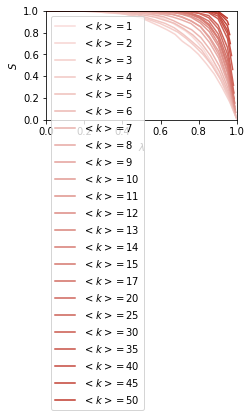

In [661]:
plt.figure(figsize=(3.42, 2.0), frameon=False)
cmap_b = ulf.cmap_in_categories(range(1, 16) + [17] + range(20, 55, 5), cmap_style=soft_reds)
for k, data_iter in data.items():
    if k >= 1:
        plt.plot(data_iter['jsdiv'], data_iter['S'], label="$<k>=$%s" % str(k), c=cmap_b(k))
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$\lambda$")
plt.ylabel("$S$")
plt.savefig("figures/interlayer_sparsity.pdf")
plt.show()

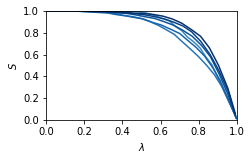

In [609]:
plt.figure(figsize=(3.42, 2.0), frameon=False)
cmap_b = ulf.cmap_in_range([min(data)-10, max(data)], cmap_style="Blues")
for k, data_iter in data.items():
    if k >= 1:
        plt.plot(data_iter['jsdiv'], data_iter['S'], label="$<k>=$%s" % str(k), c=cmap_b(k))
#plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$\lambda$")
plt.ylabel("$S$")
#plt.savefig("figures/interlayer_sparsity.pdf")
plt.show()

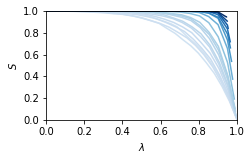

In [607]:
plt.figure(figsize=(3.42, 2.0), frameon=False)
cmap_b = ulf.cmap_in_range([min(data)-10, max(data)], cmap_style="Blues")
for k, data_iter in data.items():
    if k >= 1:
        plt.plot(data_iter['jsdiv'], data_iter['S'], label="$<k>=$%s" % str(k), c=cmap_b(k))
#plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$\lambda$")
plt.ylabel("$S$")
#plt.savefig("figures/interlayer_sparsity.pdf")
plt.show()

In [ ]:
def morph_from_G1_to_G2(G, Gt, num_swaps):
    """Exchanges num_swaps edges from G with num_swap edges from Gt"""
    def _dependent_edge_swaps(Gs, Gt):
        
        Gc = Gs.copy()
        
        empty = 0
        done = False
        
        try:
            u, x = choice(list(set(Gc.edges()) - set(Gt.edges())))  # REMOVE random edge not in Gt
            Gc.remove_edge(u, x)
        except IndexError:
            done += 1
        
        try:
            v, y = choice(list(set(Gt.edges()) - set(Gc.edges())))  # ADD random edge not in Gc
            d = Gt.get_edge_data(v, y)
            Gc.add_edge(v, y, d)
        except IndexError:
            done += 1
        
        if done == 2:
            done = True
            
        return Gc, done
    
    def _jaccard_sim(a, b):
        return len(a & b) * 1.0 / len(a | b)
    
    Gs = G.copy()
    
    for _ in range(num_swaps):
        
        Gs, done = _dependent_edge_swaps(Gs, Gt)
        
        if done:
            if _jaccard_sim(set(Gs.edges()), set(Gt.edges())) != 1:
                Gs = Gt
            break
    return Gs



In [588]:
def morph_from_G1_to_G2(Gs, Gt, num_swaps):

    Gc = Gs.copy()
    Gt = Gt.copy()

    edges_in_Gc_not_in_Gt = list(set(Gc.edges()) - set(Gt.edges()))
    num_removals_possible = min(num_swaps, len(edges_in_Gc_not_in_Gt))
    u_x = random.sample(edges_in_Gc_not_in_Gt, num_removals_possible)
    Gc.remove_edges_from(u_x)

    edges_in_Gt_not_in_Gc = list(set(Gt.edges()) - set(Gc.edges()))
    num_additions_possible = min(num_swaps, len(edges_in_Gt_not_in_Gc))
    v_y = random.sample(edges_in_Gt_not_in_Gc, num_additions_possible)
    Gc.add_edges_from(v_y)

    def _jaccard_sim(a, b):
        return len(a & b) * 1.0 / len(a | b)
    
    if num_removals_possible != num_swaps & num_additions_possible != num_swaps:
        if _jaccard_sim(set(Gc.edges()), set(Gt.edges())) != 1:
            Gc = Gt

    return Gc



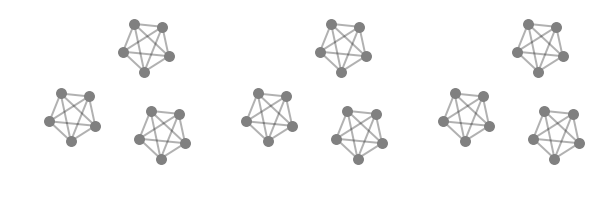

In [596]:
G1 = get_random_G(3, 5, 100)
G2 = get_random_G(3, 5, 100)
Gt = morph_from_G1_to_G2(G1, G2, 22)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
ulf.draw(G1)
plt.subplot(1, 3, 2)
ulf.draw(G2)
plt.subplot(1, 3, 3)
ulf.draw(Gt)
plt.show()

In [538]:
len(Gt.edges())

6715